# UTILS-COHERENCE_NETWORKS

This notebook demonstrates the coherence-based functional connectivity (FC) network construction pipeline.

**Key differences from correlation-based FC:**
- Uses magnitude-squared coherence (MSC) instead of Pearson correlation
- Captures linear oscillatory coupling (amplitude + phase consistency)
- Employs multitaper spectral estimation for robust frequency-domain analysis
- Optional soft sparsification via circular shift surrogates (no backbone extraction)

**Output format:**
- Same as correlation-based FC: dict of {band_name: adjacency_matrix}
- Compatible with downstream LRG analysis code

In [2]:
# figures inline
%matplotlib inline

# import the lrgsglib package
from lrgsglib import move_to_rootf

move_to_rootf(pathname='lrg_eegfc')

from lrg_eegfc.notebook import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Figure output path
path_data = Path('data')
path_seeg_data = path_data / 'stereoeeg_patients'
path_figs = path_data / 'figures' / 'UTILS-COHERENCE_NETWORKS'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


## 1. Load Data

Load SEEG data using the standard data loader.

In [3]:
# Load data
data_dict, int_label_map = load_data_dict(pat_list=['Pat_02'])
print('✓ Data loaded')
print(f'  Patients: {list(data_dict.keys())}')
print(f'  Phases: {list(data_dict[list(data_dict.keys())[0]].keys())}')

✓ Data loaded
  Patients: ['Pat_02']
  Phases: ['rsPre', 'taskLearn', 'taskTest', 'rsPost']


## 2. Select Patient and Phase

Choose a patient and recording phase for analysis.

In [4]:
# Select patient and phase
patient_id = list(data_dict.keys())[0]  # First patient
phase = 'rsPre'  # Resting state pre-task

# Extract data
patient_data = data_dict[patient_id][phase]
X = patient_data['data']  # (N, L) array
fs = patient_data['fs'][0][0]  # Sampling frequency

print(f'Patient: {patient_id}')
print(f'Phase: {phase}')
print(f'Data shape: {X.shape} (N channels, L samples)')
print(f'Sampling frequency: {fs} Hz')
print(f'Duration: {X.shape[1] / fs:.2f} seconds')

Patient: Pat_02
Phase: rsPre
Data shape: (117, 1323208) (N channels, L samples)
Sampling frequency: 2048 Hz
Duration: 646.10 seconds


## 3. Coherence-Based FC Pipeline

### 3.1 Quick Example: Dense MSC (No Sparsification)

Compute band-averaged magnitude-squared coherence without sparsification.

In [5]:
from lrg_eegfc.utils.coherence import coherence_fc_pipeline
from lrg_eegfc.config.const import BRAIN_BANDS

# Compute dense MSC matrices (no sparsification)
msc_matrices = coherence_fc_pipeline(
    X,
    fs,
    bands=BRAIN_BANDS,
    sparsify="none",  # No sparsification
    nperseg=512,      # Window length for spectral estimation
)

print('✓ Dense MSC matrices computed')
print(f'  Bands: {list(msc_matrices.keys())}')
print(f'  Matrix shape: {msc_matrices[list(msc_matrices.keys())[0]].shape}')

✓ Dense MSC matrices computed
  Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']
  Matrix shape: (117, 117)


### 3.2 Visualize Dense MSC Matrices

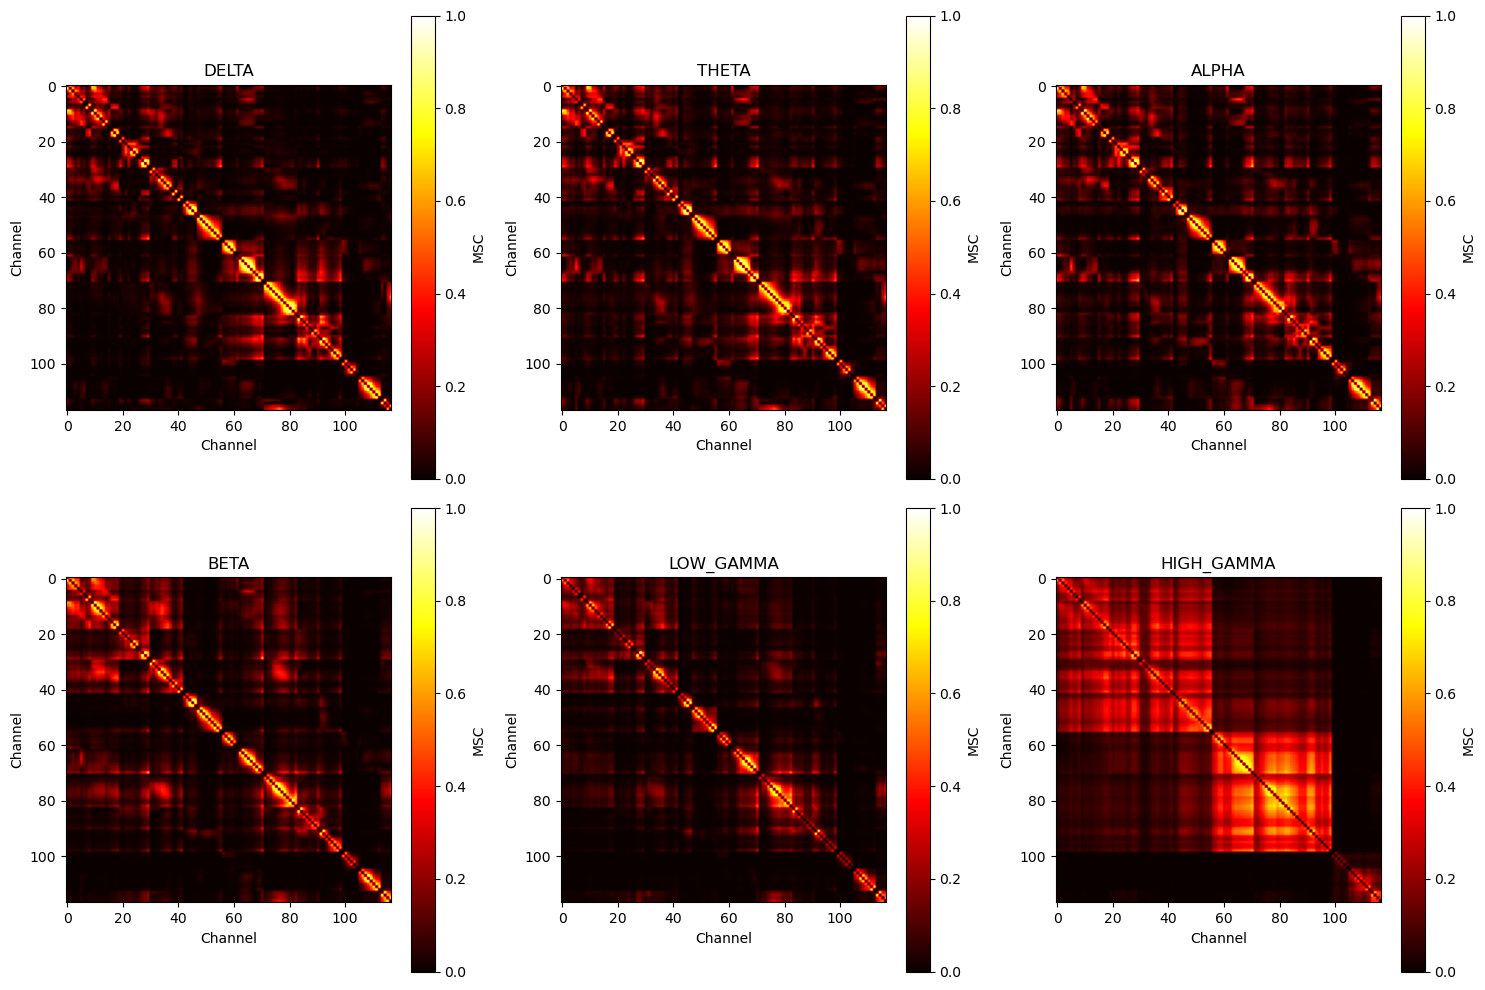

✓ Dense MSC matrices visualized


In [6]:
# Plot MSC matrices for all bands
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (band_name, W) in enumerate(msc_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(W, cmap='hot', vmin=0, vmax=1)
    ax.set_title(f'{band_name.upper()}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='MSC')

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_msc_dense.png', dpi=150)
plt.show()

print('✓ Dense MSC matrices visualized')

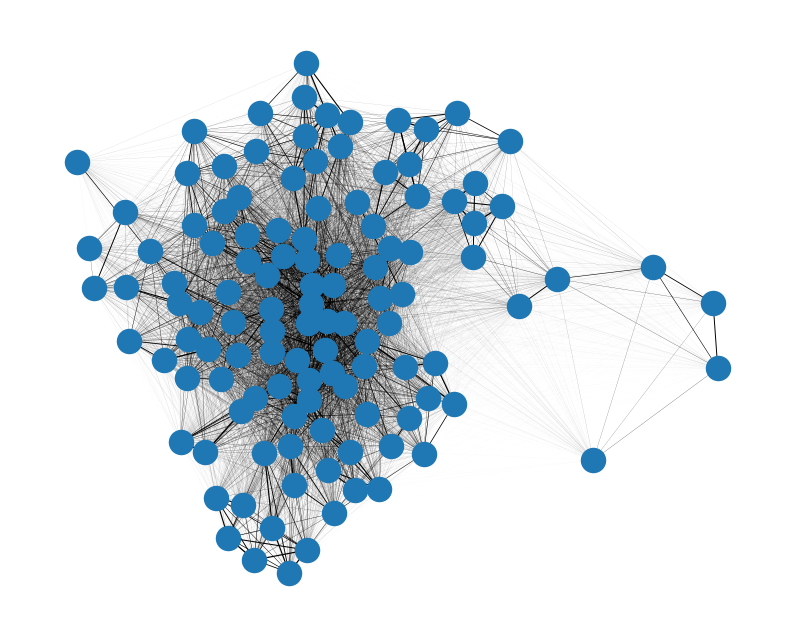

In [11]:
from lrgsglib import *

cc = msc_matrices['alpha']
G, rnodes = get_giant_component_leftoff(nx.from_numpy_array(cc))
# label_dict = {k: v for k, v in pin_labels.to_dict().items() if k not in rnodes}
pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(figsize=(10, 8))
widths = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(
    G, pos,
    width=widths,
)

### 3.3 Soft Sparsification with Surrogates

Apply soft sparsification using circular shift surrogates to downweight non-significant edges.

**Note:** This may take a few minutes depending on the number of surrogates.

In [13]:
# Compute soft-sparsified adjacency matrices
# Start with fewer surrogates for quick testing (increase to 200 for final analysis)
adj_matrices = coherence_fc_pipeline(
    X,
    fs,
    bands=BRAIN_BANDS,
    n_surrogates=50,   # Use 200 for final analysis
    sparsify="soft",   # Soft sparsification
    nperseg=256,
    zero_diagonal=True,
)

print('✓ Soft-sparsified adjacency matrices computed')
print(f'  Bands: {list(adj_matrices.keys())}')
print(f'  Matrix shape: {adj_matrices[list(adj_matrices.keys())[0]].shape}')

KeyboardInterrupt: 

### 3.4 Visualize Soft-Sparsified Matrices

In [ ]:
# Plot soft-sparsified adjacency matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (band_name, A) in enumerate(adj_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(A, cmap='hot', vmin=0, vmax=np.max(A))
    ax.set_title(f'{band_name.upper()} (Soft-Sparsified)')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='Weighted MSC')

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_msc_soft_sparsified.png', dpi=150)
plt.show()

print('✓ Soft-sparsified adjacency matrices visualized')

### 3.5 Compare Dense vs Sparsified

Compare the weight distributions before and after soft sparsification.

In [ ]:
# Compare for one band (e.g., alpha)
band = 'alpha'

# Extract upper triangular values (excluding diagonal)
N = msc_matrices[band].shape[0]
triu_idx = np.triu_indices(N, k=1)

W_values = msc_matrices[band][triu_idx]
A_values = adj_matrices[band][triu_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of dense MSC
axes[0].hist(W_values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('MSC Value')
axes[0].set_ylabel('Count')
axes[0].set_title(f'{band.upper()} - Dense MSC Distribution')
axes[0].grid(alpha=0.3)

# Histogram of soft-sparsified
axes[1].hist(A_values, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Weighted MSC Value')
axes[1].set_ylabel('Count')
axes[1].set_title(f'{band.upper()} - Soft-Sparsified Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_{band}_comparison.png', dpi=150)
plt.show()

print(f'✓ Comparison for {band} band')
print(f'  Dense MSC - Mean: {W_values.mean():.4f}, Std: {W_values.std():.4f}')
print(f'  Soft-Sparsified - Mean: {A_values.mean():.4f}, Std: {A_values.std():.4f}')
print(f'  Sparsity (edges with weight < 0.01): {(A_values < 0.01).sum() / len(A_values) * 100:.1f}%')

## 4. Network Statistics

Compute basic network statistics for the soft-sparsified adjacency matrices.

In [ ]:
import networkx as nx

# Compute network statistics for each band
stats = {}
for band_name, A in adj_matrices.items():
    # Create weighted graph
    G = nx.from_numpy_array(A)
    
    # Remove very weak edges for cleaner statistics
    threshold = 0.01
    edges_to_remove = [(u, v) for u, v, w in G.edges(data='weight') if w < threshold]
    G.remove_edges_from(edges_to_remove)
    
    stats[band_name] = {
        'n_nodes': G.number_of_nodes(),
        'n_edges': G.number_of_edges(),
        'density': nx.density(G),
        'n_components': nx.number_connected_components(G),
        'mean_degree': np.mean([d for n, d in G.degree()]),
    }

# Display statistics
print('Network Statistics (threshold = 0.01):')
print('=' * 70)
for band_name, stat in stats.items():
    print(f'{band_name:12s} | Nodes: {stat["n_nodes"]:3d} | Edges: {stat["n_edges"]:4d} | '
          f'Density: {stat["density"]:.4f} | Components: {stat["n_components"]:2d} | '
          f'Mean Degree: {stat["mean_degree"]:.2f}')
print('=' * 70)

## 5. Custom Bands Example

Demonstrate using custom frequency bands instead of the default brain bands.

In [ ]:
# Define custom bands
custom_bands = {
    'slow': (0.5, 4.0),
    'medium': (4.0, 30.0),
    'fast': (30.0, 100.0),
}

# Compute MSC for custom bands
custom_adj = coherence_fc_pipeline(
    X,
    fs,
    bands=custom_bands,
    n_surrogates=50,
    sparsify="soft",
    nperseg=256,
)

print('✓ Custom band adjacency matrices computed')
print(f'  Custom bands: {list(custom_adj.keys())}')

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (band_name, A) in enumerate(custom_adj.items()):
    ax = axes[idx]
    im = ax.imshow(A, cmap='hot', vmin=0, vmax=np.max(A))
    fmin, fmax = custom_bands[band_name]
    ax.set_title(f'{band_name.upper()} ({fmin}-{fmax} Hz)')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='Weighted MSC')

plt.tight_layout()
plt.savefig(path_figs / f'{patient_id}_{phase}_custom_bands.png', dpi=150)
plt.show()

## 6. Integration with LRG Analysis

The output format is identical to correlation-based FC, so downstream LRG analysis code works unchanged.

Example: The adjacency matrices can be directly used with the LRG clustering and ultrametric analysis functions from `lrgsglib`.

In [ ]:
# Example: Use adjacency matrix with LRG analysis (placeholder)
print('✓ Adjacency matrices ready for LRG analysis')
print('  Use adj_matrices[band_name] with:'')
print('  - lrgsglib.utils.lrg.clustering functions')
print('  - lrgsglib.utils.lrg.spectral functions')
print('  - Ultrametric distance comparisons')
print('  - Hierarchical clustering analysis')

## Summary

This notebook demonstrated:

1. **Loading SEEG data** using the standard data loader
2. **Computing dense MSC matrices** without sparsification
3. **Soft sparsification** using circular shift surrogates
4. **Comparing dense vs sparsified** weight distributions
5. **Computing network statistics** from adjacency matrices
6. **Using custom frequency bands** for analysis

**Key advantages of coherence-based FC:**
- Captures frequency-specific linear oscillatory coupling
- Robust multitaper spectral estimation
- Soft sparsification preserves weight geometry (no hard thresholding)
- Compatible with existing LRG analysis pipeline

**Next steps:**
- Apply to all patients and phases
- Use with LRG ultrametric analysis
- Compare correlation-based vs coherence-based FC networks